In [2]:
import torch
import pandas as pd 
import numpy as np
from transformer import VanillaTimeSeriesTransformer_EncoderOnly, VanillaTimeSeriesTransformer
from utils import Trainer, preprocess_data, seed_everything
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import pickle 


seed_everything()

In [3]:
class ModelTrainingManager:
    """
    ModelTrainingManager: Manages the entire model training and testing pipeline for PyTorch models.

    Attributes:
    - model_name: Name of the model class to be instantiated and trained.
    - df_path: Path to the dataset in CSV format.
    - best_path: Path to the best hyperparameters found during tuning.
    - top_features_num: Number of top features to use from the dataset.
    - input_len: Length of input sequences.
    - next_ith: Next ith data point to predict.
    - top_features_path: Path to the selected top features.
    - batch_size: Batch size for training (default: 256).
    - num_epochs: Number of training epochs (default: 100).
    - early_stopping_patience_limit: Number of epochs with no improvement after which training stops (default: 10).
    - device: Device specification for training, e.g., 'cuda:0' (default) or 'cpu'.
    - model_file_path: File path to save the best model (default: "models/best_model.pt").
    - is_save_model: Whether to save the best model during training based on validation performance (default: True).
    - is_plot: Whether to plot training and validation losses (default: True).
    - is_plot_and_plot_test: Additional plotting parameter (default: False).

    Methods:
    - preprocess_data(): Loads data from df_path, applies preprocessing, and splits into train, validation, and test datasets.
    - load_model(): Loads best hyperparameters and initializes model with best hyperparameters.
    - compile_and_train(): Sets up loss, optimizer, and scheduler; initializes a Trainer object and trains the model.
    - test(): Tests the trained model on the test dataset and calculates performance metrics (MSE, MAE).
    - run_training_testing(): Executes the full pipeline from data preprocessing to testing.
    """
    def __init__(self, model_name, df_path, best_path, top_features_num, input_len, next_ith, top_features_path='../data/top_feattures.pkl',
                 batch_size=256, num_epochs=100, early_stopping_patience_limit=10, device='cuda:0', 
                 model_file_path="models/best_model.pt", is_save_model=True, is_plot=True, is_plot_and_plot_test=False):
        
        self.model_name = model_name
        self.df_path = df_path
        self.best_path = best_path
        self.top_features_num = top_features_num
        self.input_len = input_len
        self.next_ith = next_ith
        self.top_features_path = top_features_path
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.early_stopping_patience_limit = early_stopping_patience_limit
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model_file_path = model_file_path
        self.is_save_model = is_save_model
        self.is_plot = is_plot
        self.is_plot_and_plot_test = is_plot_and_plot_test

    def preprocess_data(self):
        self.df = pd.read_csv(self.df_path)
        with open(self.top_features_path, 'rb') as file:
            top_feattures = pickle.load(file)
        top_feattures = top_feattures[:self.top_features_num]
        top_feattures.append('close')
        self.df = self.df[top_feattures]
        
        # preprocessing filtered df
        self.scaled_df, _, self.scaler_close, self.train_dataloader, self.val_dataloader, self.test_dataloader = preprocess_data(
            self.df, batch_size=self.batch_size, input_seq_len=self.input_len, output_seq_len=self.next_ith)

    def load_model(self):
        with open(self.best_path, 'rb') as file:
            self.best = pickle.load(file)

        # assigning model's hyperparameters based on the tuning
        model_params = {
            "num_features": int(len(self.scaled_df.columns)),
            "num_layers": int(self.best["num_layers"]),
            "num_heads": int(self.best["num_heads"]),
            "d_model": int(self.best['d_model_by_num_heads']) * int(self.best["num_heads"]),
            "dff": int(self.best['dff']),
            "mlp_size": int(self.best['mlp_size']), # size of the first MLP layer
            "dropout_rate": round(self.best['dropout_rate'], 3),  # dropout rate for the Transformer layers
            "mlp_dropout_rate": round(self.best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers
        }

        # instantiating model itself
        self.model = eval(self.model_name)(**model_params)
        self.model = self.model.to(self.device)


    def compile_and_train(self):
        self.criterion = MSELoss() 
        self.optimiser = Adam(self.model.parameters(), lr=round(self.best['lr'], 6))
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimiser, 'min', factor=0.9, patience=5)

        # declaring trainer object
        self.model_trainer = Trainer(model=self.model,
                            train_dataloader=self.train_dataloader,
                            val_dataloader=self.val_dataloader,
                            test_dataloader=self.test_dataloader,
                            criterion=self.criterion,
                            optimiser=self.optimiser,
                            scheduler=self.scheduler,
                            device=self.device,
                            num_epochs=self.num_epochs,
                            early_stopping_patience_limit=self.early_stopping_patience_limit,
                            is_save_model=self.is_save_model,
                            scaler=self.scaler_close,
                            file_path = self.model_file_path)
        # training
        self.train_losses, self.val_losses = self.model_trainer.train_loop(is_plot=self.is_plot, 
                                                                           is_plot_and_plot_test=self.is_plot_and_plot_test)

    def test(self):
        # testing
        self.mse, self.mae = self.model_trainer.test_model()

    def run_training_testing(self):
        self.preprocess_data()
        self.load_model()
        self.compile_and_train()
        self.test()


# Vanilla Transformer - Encoder Only

#### Close Column Only (Input: last 96 data points, Output: the next first future data)

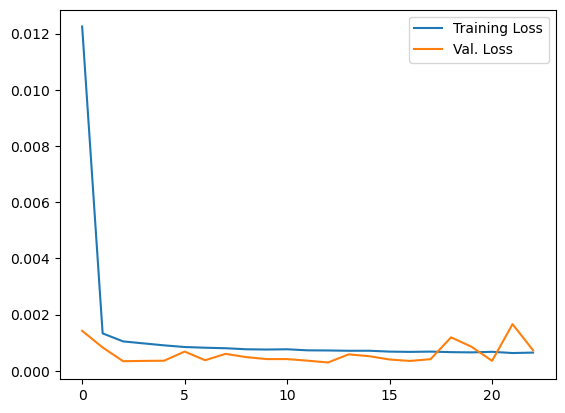

Current MAE 0.02174846744417038
Best MAE 0.012512861521131804
Early stopping triggered
Test MSE: 700792.8125, Test MAE: 601.8746948242188


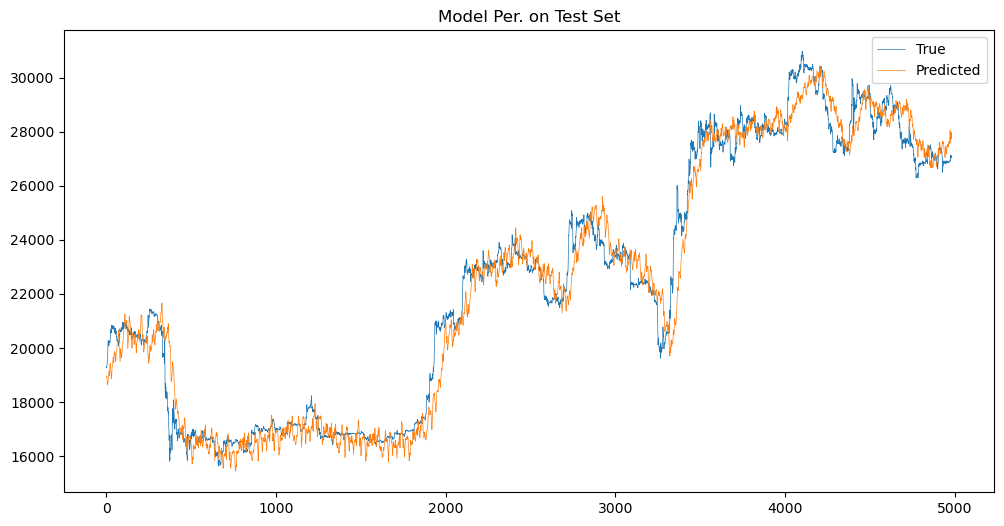

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_96_1.pt").run_training_testing()

#### Top 2 Features (Input: last 96 data points, Output: the next first future data)

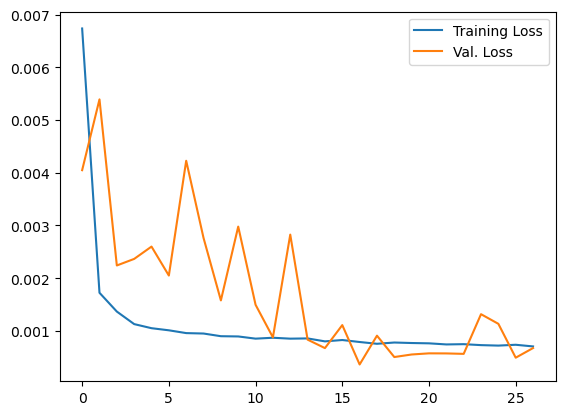

Current MAE 0.02196412134089824
Best MAE 0.014164168170093742
Early stopping triggered
Test MSE: 1965491.875, Test MAE: 1167.163330078125


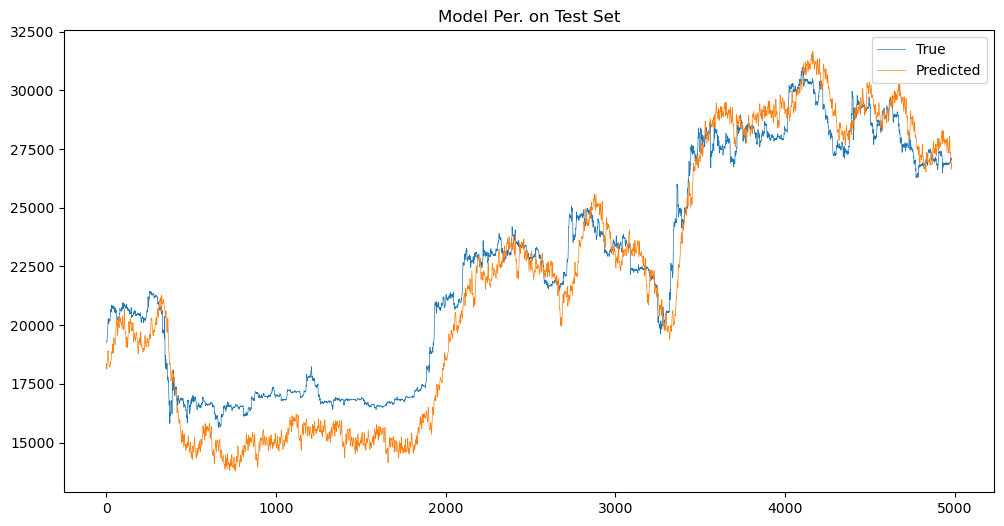

In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=2, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&2_col_best_model_96_1.pt").run_training_testing()

#### Top 5 Features (Input: last 96 data points, Output: the next first future data)

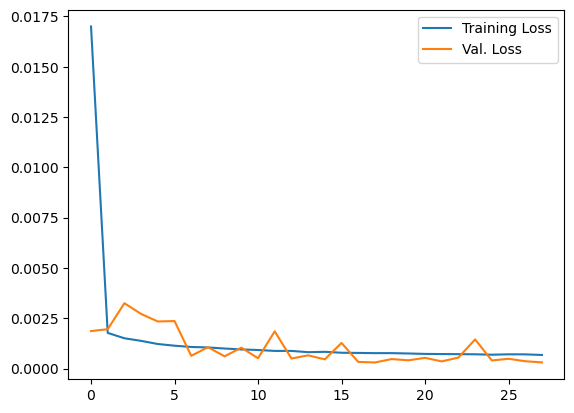

Current MAE 0.013025386254195734
Best MAE 0.012937648601852425
Early stopping triggered
Test MSE: 1156210.875, Test MAE: 838.0816040039062


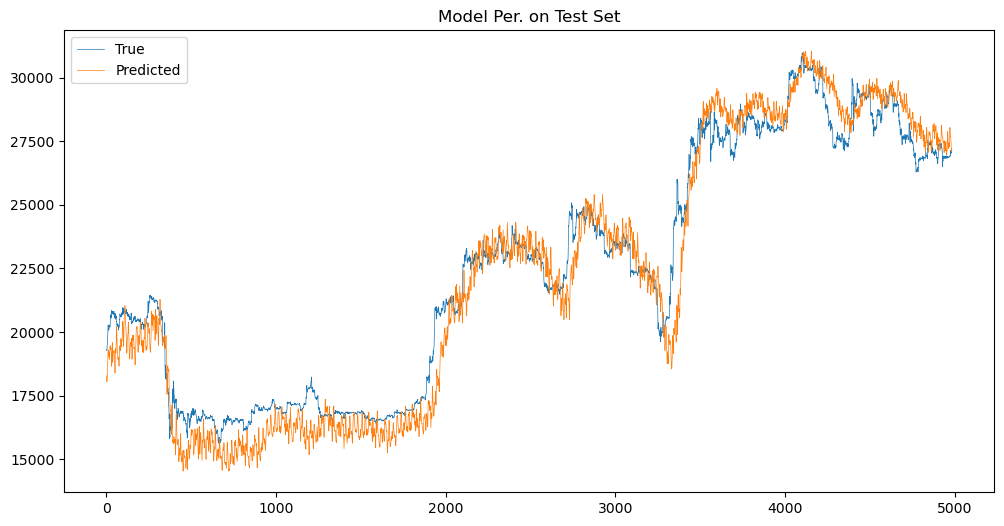

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=5, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&5_col_best_model_96_1.pt").run_training_testing()

#### Top 10 Features (Input: last 96 data points, Output: the next first future data)

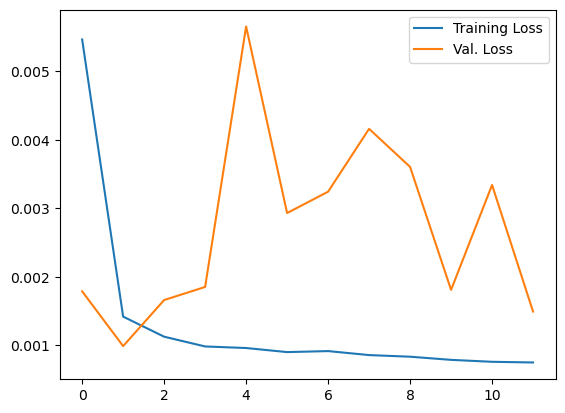

Current MAE 0.03321690494297381
Best MAE 0.025640094181599325
Early stopping triggered
Test MSE: 5603149.0, Test MAE: 1914.7611083984375


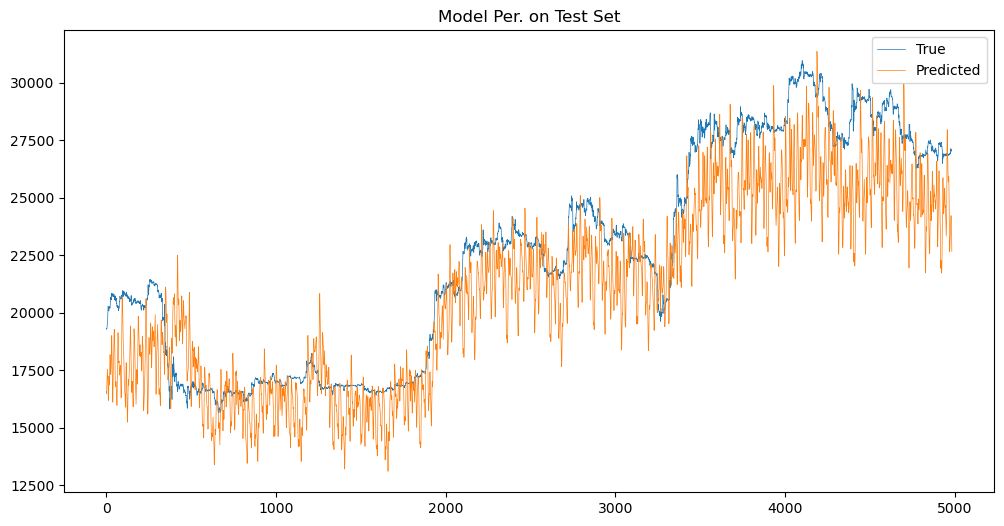

In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_96_1.pt").run_training_testing()

#### Selected Top Features (Input: last 96 data points, Output: the next 12th future data)

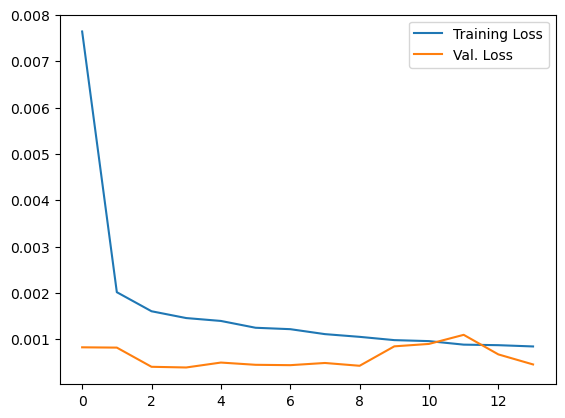

Current MAE 0.015522296534833255
Best MAE 0.014590582447081661
Early stopping triggered
Test MSE: 999788.4375, Test MAE: 751.2340698242188


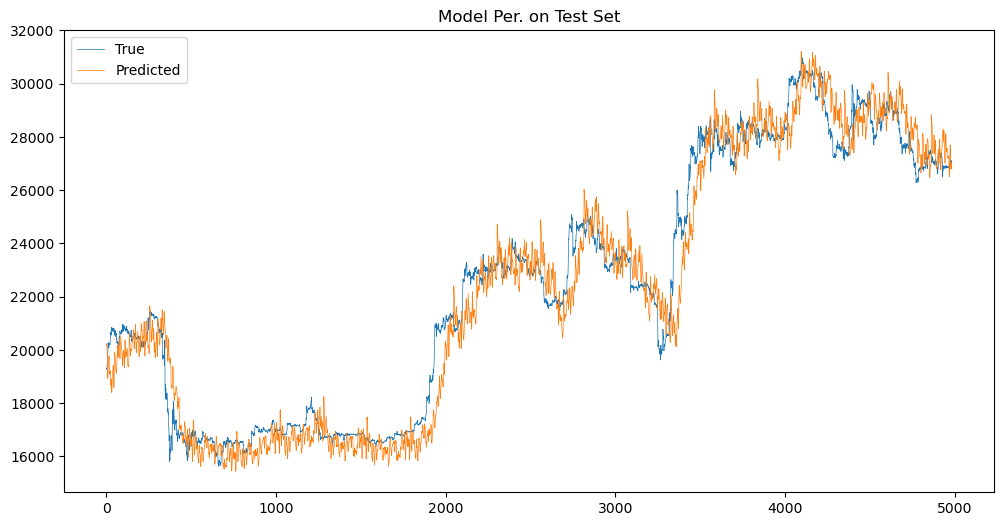

In [5]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_96_12.pt").run_training_testing()

#### Selected Top Features (Input: last 192 data points, Output: the next 24th future data)

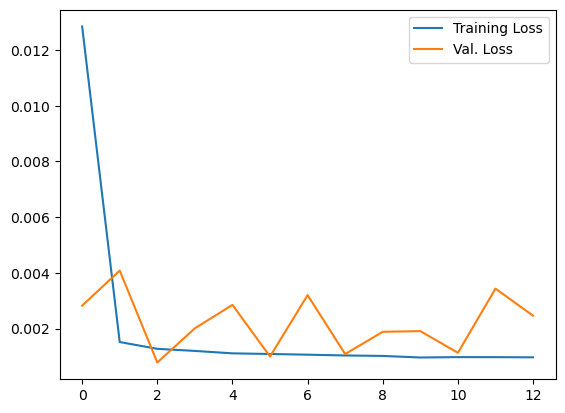

Current MAE 0.04249063599873413
Best MAE 0.01901979384596678
Early stopping triggered
Test MSE: 2261286.25, Test MAE: 1195.6412353515625


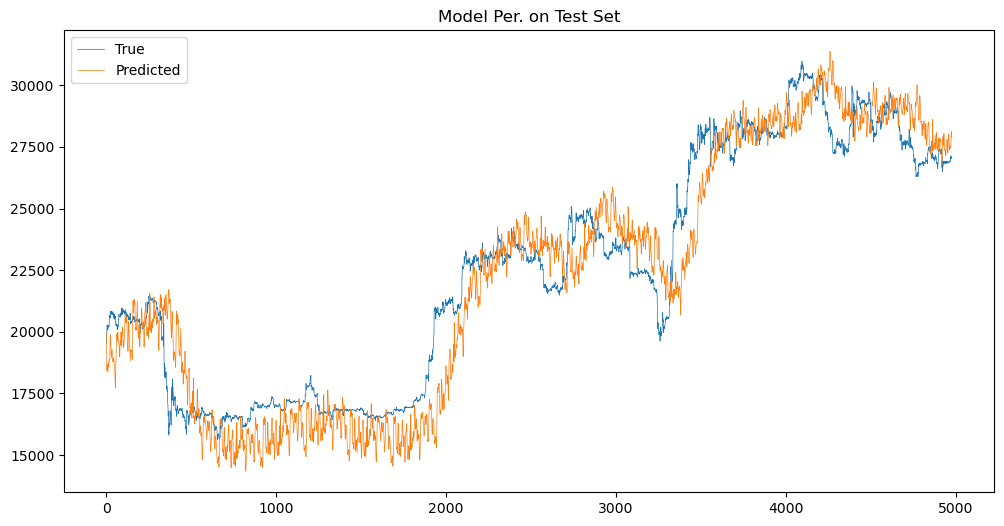

In [8]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=192, 
    next_ith=24,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_192_24.pt").run_training_testing()

## Close Column Only

#### Close Column Only (Input: last 12 data points, Output: the next First future data)

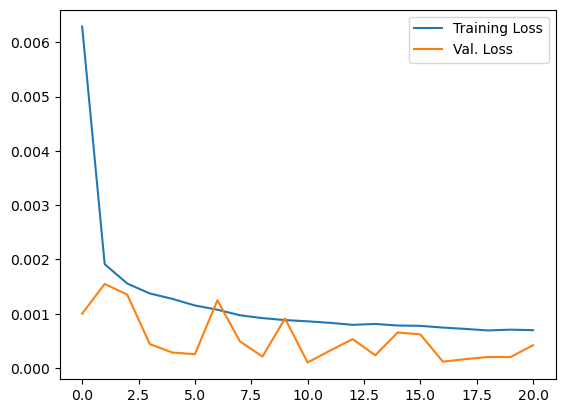

Current MAE 0.018936876842659135
Best MAE 0.007786367689650435
Early stopping triggered
Test MSE: 492610.71875, Test MAE: 568.2063598632812


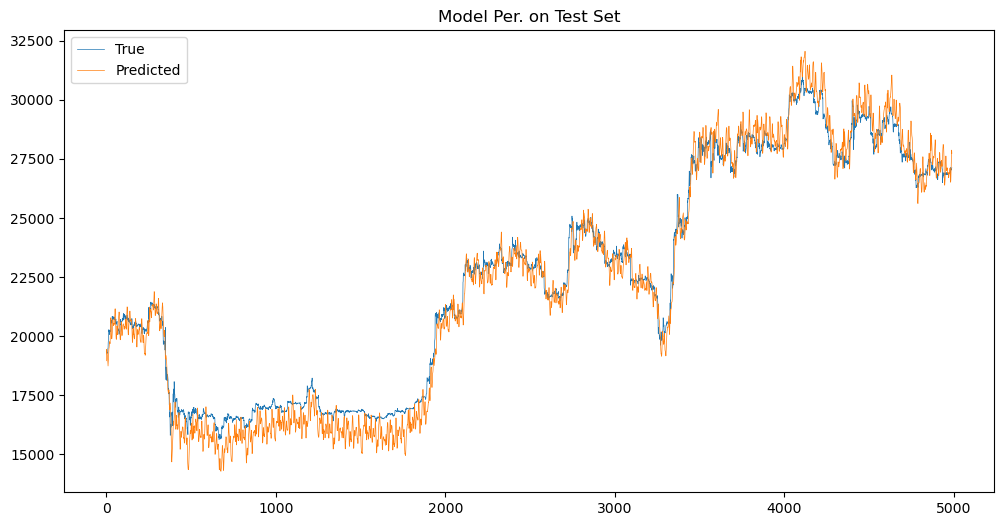

In [9]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=12, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_12_1.pt").run_training_testing()

#### Close Column Only (Input: last 12 data points, Output: the next 12th future data)

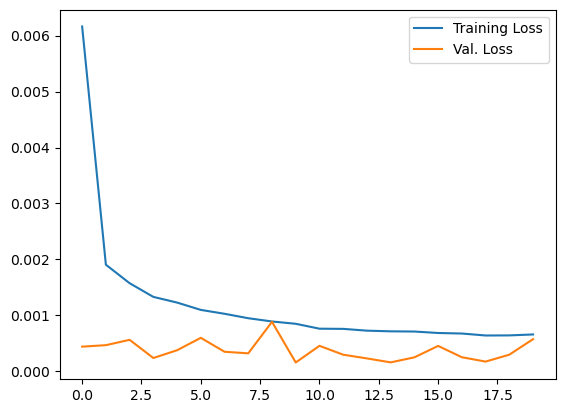

Current MAE 0.021480100840306226
Best MAE 0.009269062003961734
Early stopping triggered
Test MSE: 465627.25, Test MAE: 532.3447265625


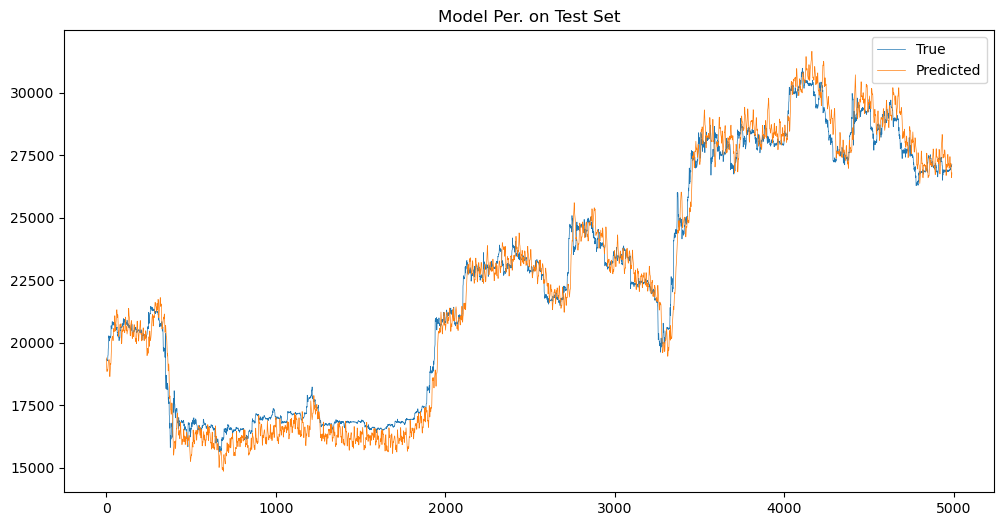

In [10]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=12, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_12_12.pt").run_training_testing()

#### Close Column Only (Input: last 96 data points, Output: the next First future data)

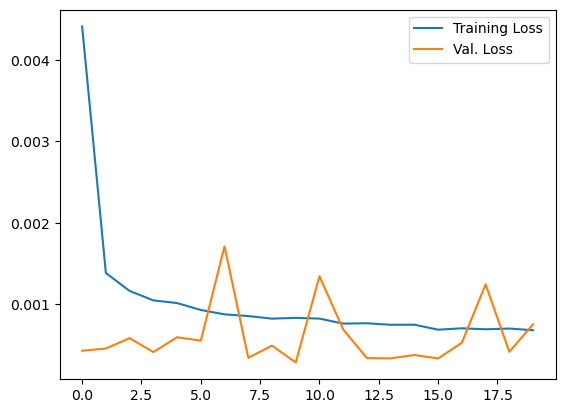

Current MAE 0.024789201372948547
Best MAE 0.013363663772066893
Early stopping triggered
Test MSE: 1370571.25, Test MAE: 958.6521606445312


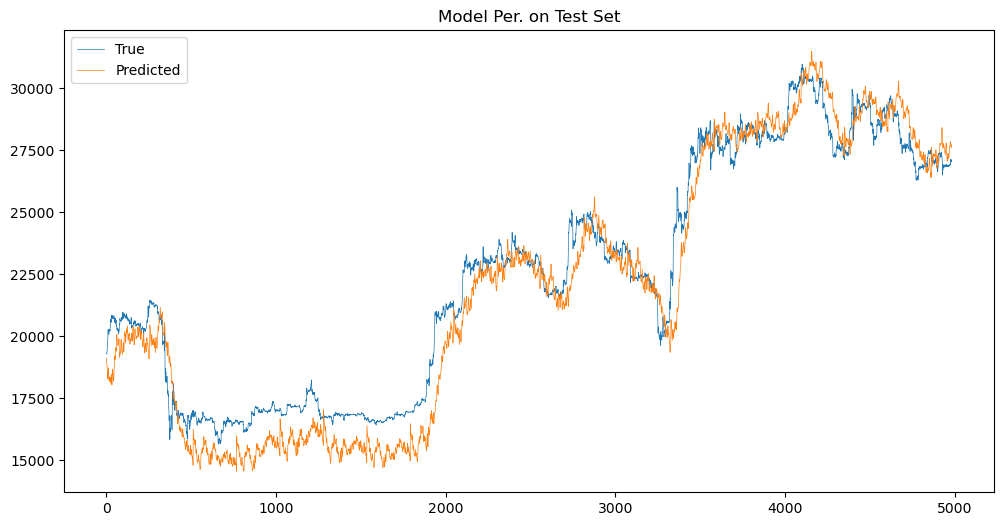

In [11]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_96_1.pt").run_training_testing()

#### Close Column Only (Input: last 96 data points, Output: the next 12th future data)

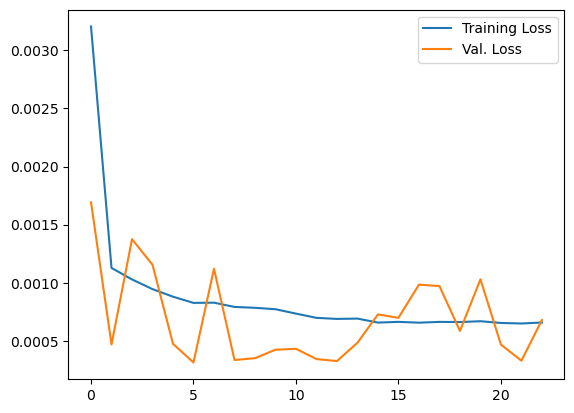

Current MAE 0.02040359349906397
Best MAE 0.012995716368250346
Early stopping triggered
Test MSE: 877252.0625, Test MAE: 679.34228515625


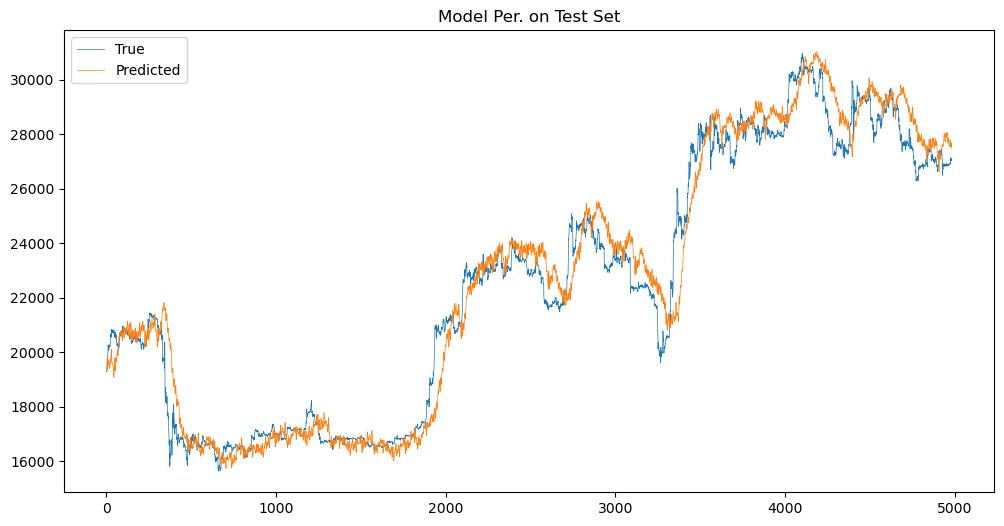

In [12]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_96_12.pt").run_training_testing()

#### Close Column Only (Input: last 504 data points, Output: the next 12 future data)

In [ ]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=504, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_504_12.pt").run_training_testing()

torch.Size([89349, 504, 1])
torch.Size([89349, 1, 1])
model name is  VanillaTimeSeriesTransformer_EncoderOnly


OutOfMemoryError: CUDA out of memory. Tried to allocate 420.00 MiB (GPU 0; 7.79 GiB total capacity; 4.34 GiB already allocated; 260.50 MiB free; 4.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Top Columns

#### Top Columns (Input: last 12 data points, Output: the next First future data)

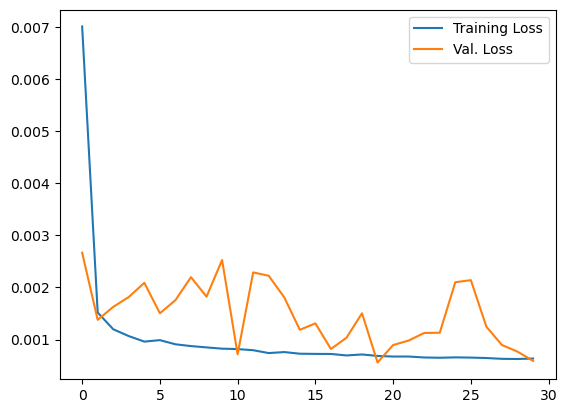

Current MAE 0.020250077361058414
Best MAE 0.018621881795783134
Early stopping triggered
Test MSE: 14410662.0, Test MAE: 3661.324462890625


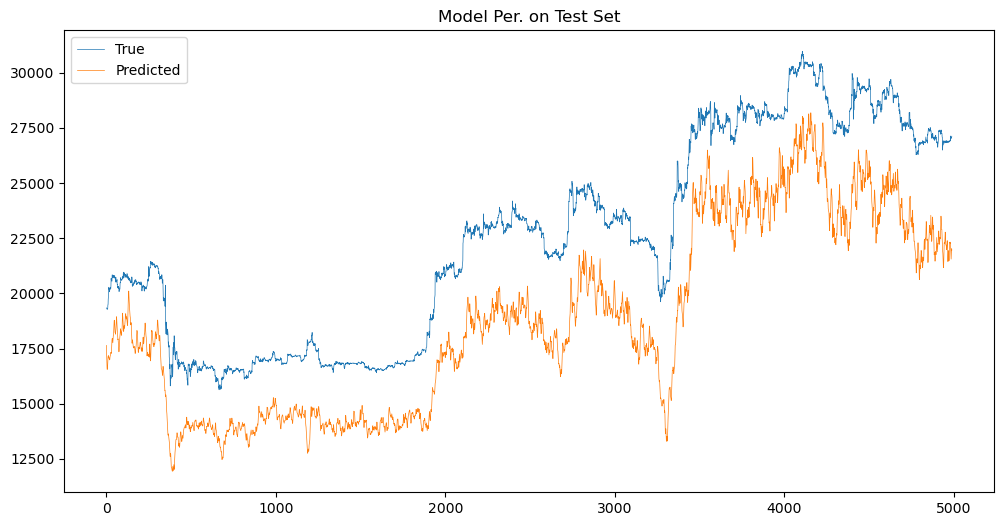

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=12, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_12_1.pt").run_training_testing()

#### Top Columns (Input: last 12 data points, Output: the next 12th future data)

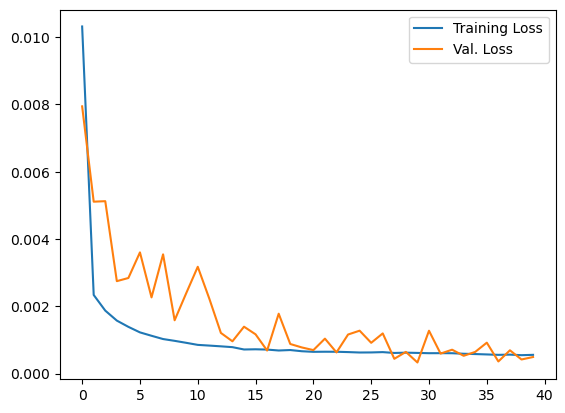

Current MAE 0.019082070836900424
Best MAE 0.014579263990020503
Early stopping triggered
Test MSE: 7229045.0, Test MAE: 2481.10205078125


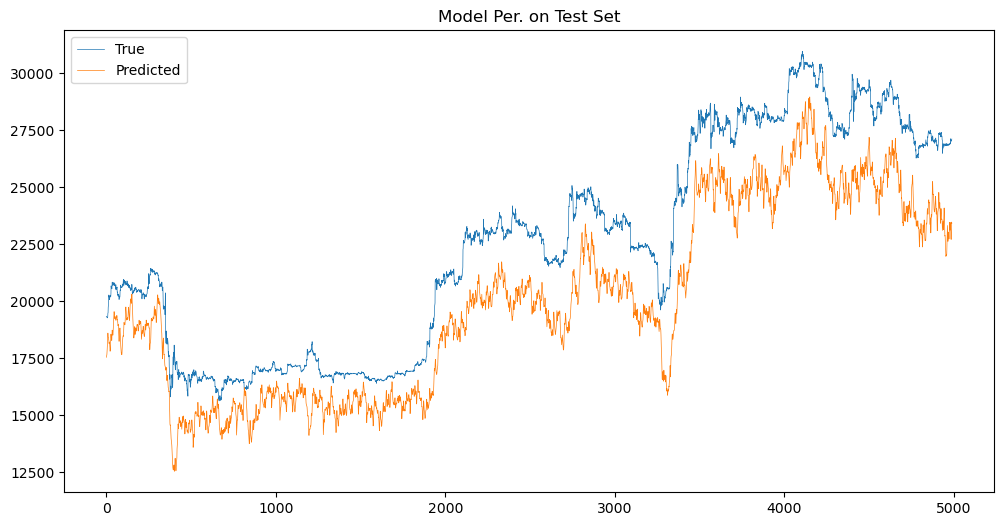

In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=12, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_12_12.pt").run_training_testing()

#### Top Columns (Input: last 96 data points, Output: the next first future data)

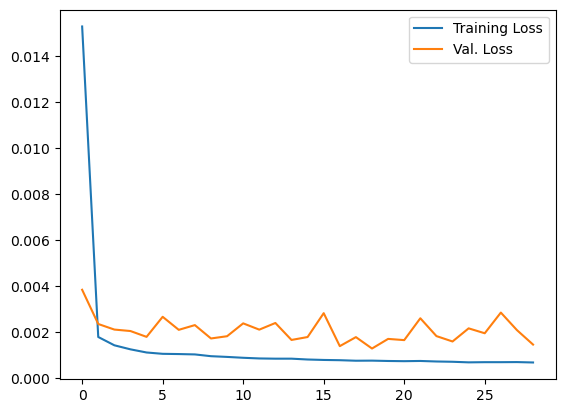

Current MAE 0.0337804838716087
Best MAE 0.028911868612111032
Early stopping triggered
Test MSE: 21519156.0, Test MAE: 4304.326171875


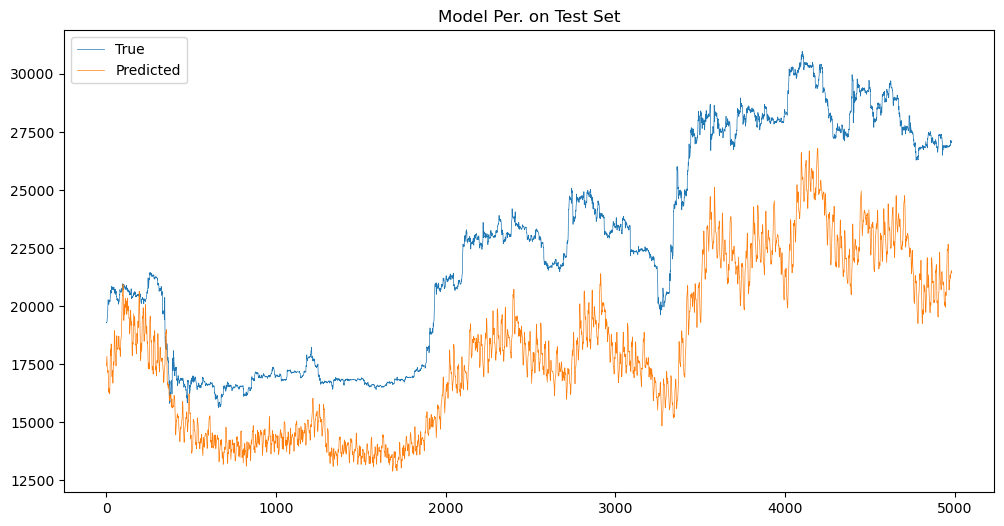

In [5]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_96_1.pt").run_training_testing()

#### Top Columns (Input: last 96 data points, Output: the next 12th future data)

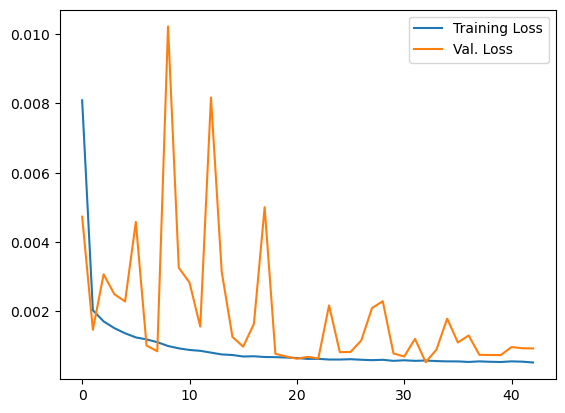

Current MAE 0.022653391684912278
Best MAE 0.01775136511372238
Early stopping triggered
Test MSE: 4512943.0, Test MAE: 1763.52099609375


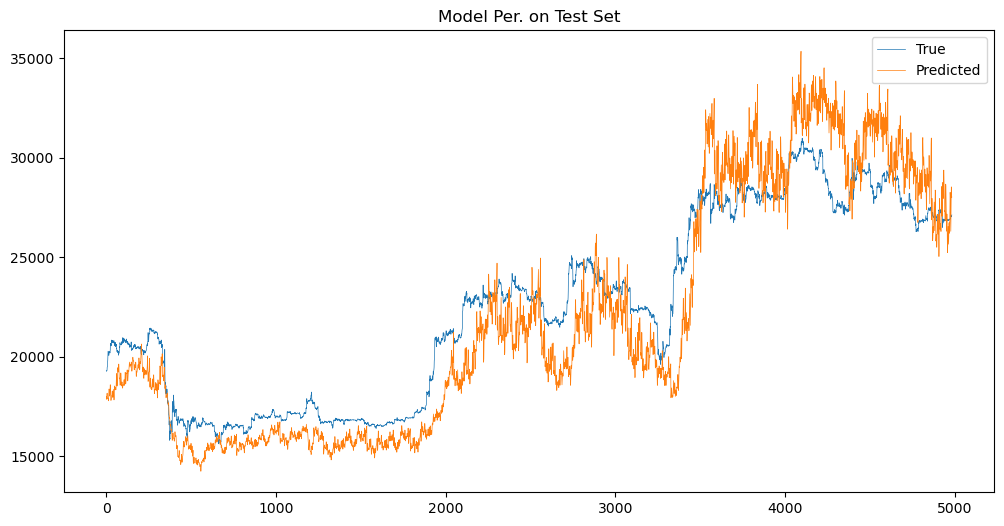

In [6]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_96_12.pt").run_training_testing()

#### Top Columns (Input: last 504 data points, Output: the next 12 future data)

In [9]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=504, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_504_12.pt").run_training_testing()

torch.Size([89349, 504, 11])
torch.Size([89349, 1, 1])
model name is  VanillaTimeSeriesTransformer_EncoderOnly


OutOfMemoryError: CUDA out of memory. Tried to allocate 420.00 MiB (GPU 0; 7.79 GiB total capacity; 4.35 GiB already allocated; 102.50 MiB free; 4.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Vanilla Transformer - Encoder Decoder (Teacher Forcing)

#### Close Column Only (Input: last 96 data points, Output: the next first future data)

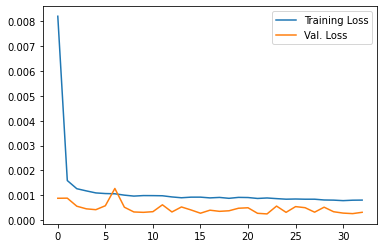

Current MAE 0.014361866290233618
Best MAE 0.011957710956241057
Early stopping triggered
Test MSE: 1129581.875, Test MAE: 872.1796264648438


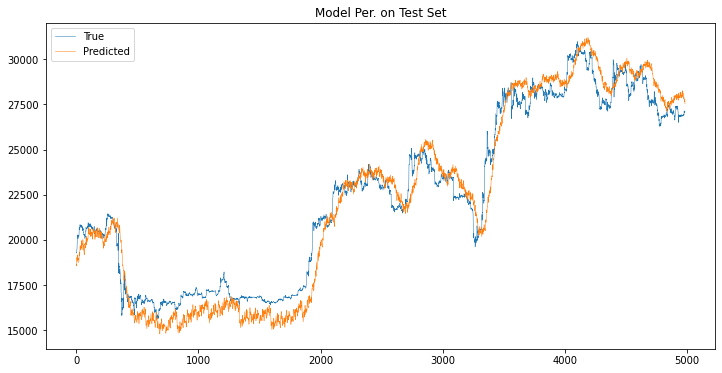

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_96_1.pt").run_training_testing()

#### Top 2 Features (Input: last 96 data points, Output: the next first future data)

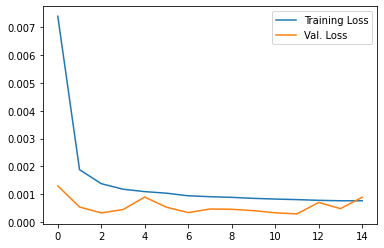

Current MAE 0.024106772890951533
Best MAE 0.012152457318138873


In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=2, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close&2_col_best_model_96_1.pt").run_training_testing()

#### Top 5 Features (Input: last 96 data points, Output: the next first future data)

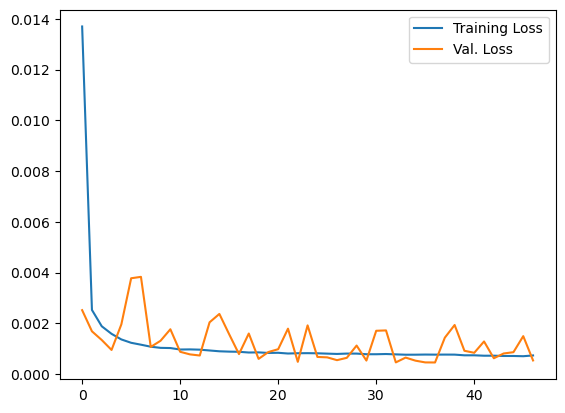

Current MAE 0.016652940333995562
Best MAE 0.015554360952415133
Early stopping triggered
Test MSE: 923090.1875, Test MAE: 744.9790649414062


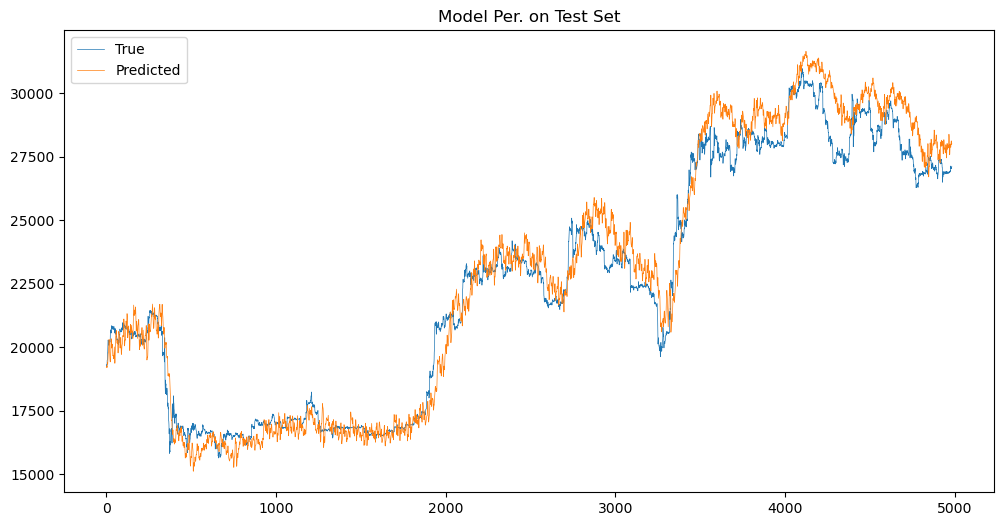

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=5, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close&5_col_best_model_96_1.pt").run_training_testing()

#### Top 10 Features (Input: last 96 data points, Output: the next first future data)

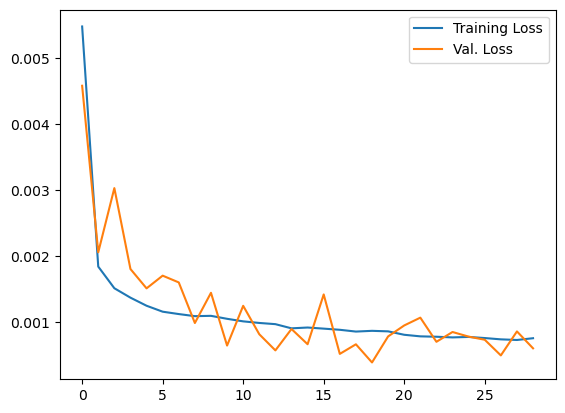

Current MAE 0.021380436062483993
Best MAE 0.01588827336250002
Early stopping triggered
Test MSE: 6063901.0, Test MAE: 2260.824951171875


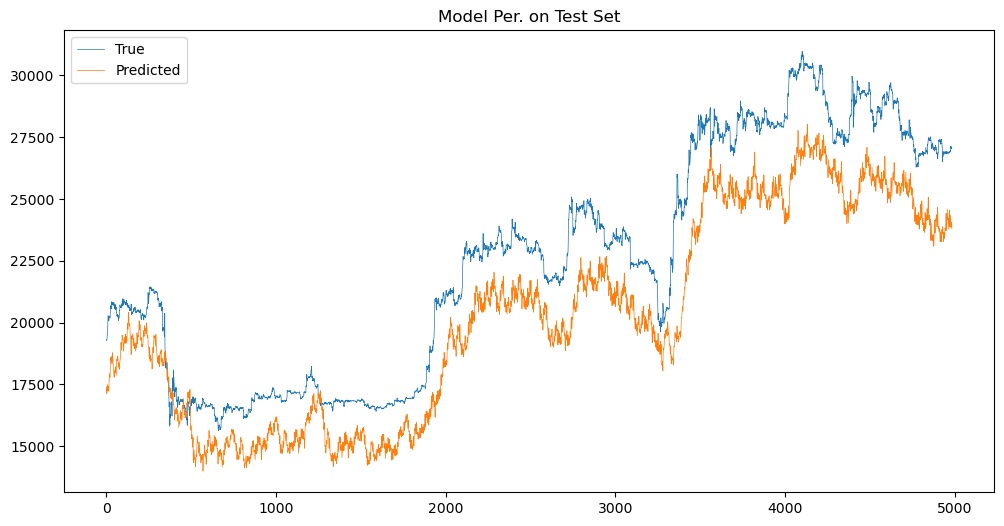

In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close&10_col_best_model_96_1.pt").run_training_testing()

#### Selected Top Features (Input: last 96 data points, Output: the next 12th future data)

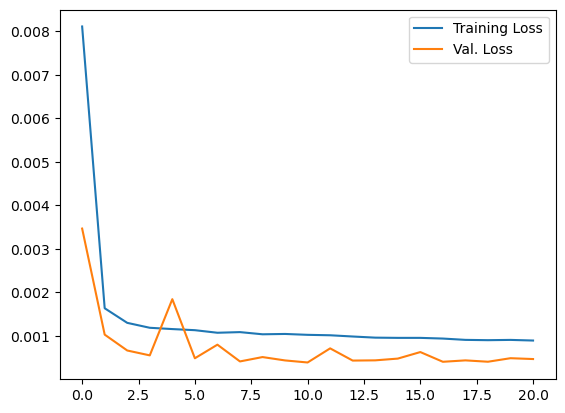

Current MAE 0.015692572056332284
Best MAE 0.014764843107968042
Early stopping triggered
Test MSE: 1315068.75, Test MAE: 897.0918579101562


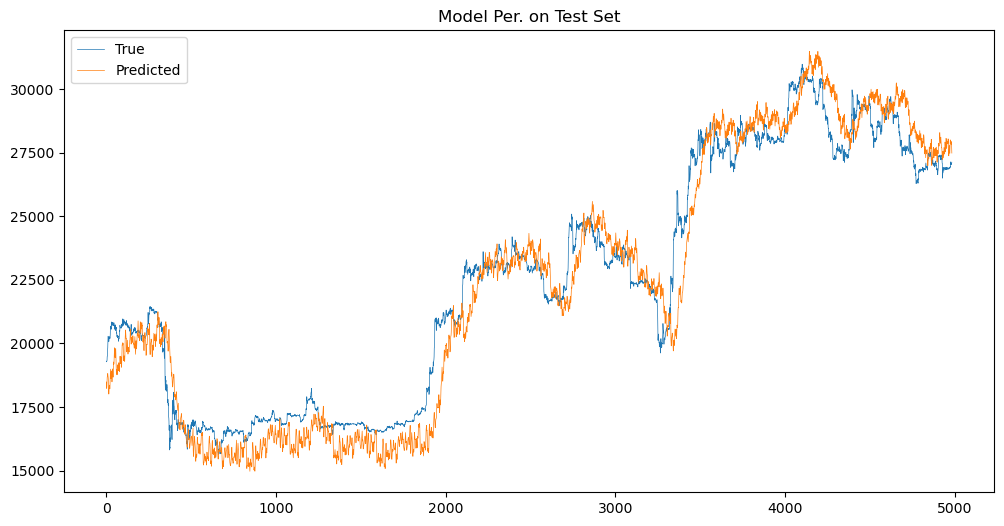

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_96_12.pt").run_training_testing()

#### Selected Top Features (Input: last 192 data points, Output: the next 24th future data)

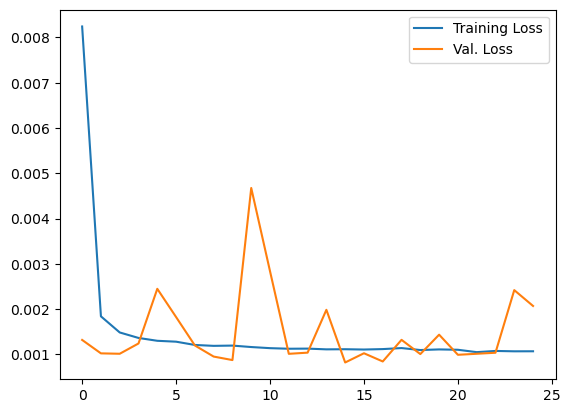

Current MAE 0.03793523500804969
Best MAE 0.02049594092085362
Early stopping triggered
Test MSE: 3279094.5, Test MAE: 1556.950439453125


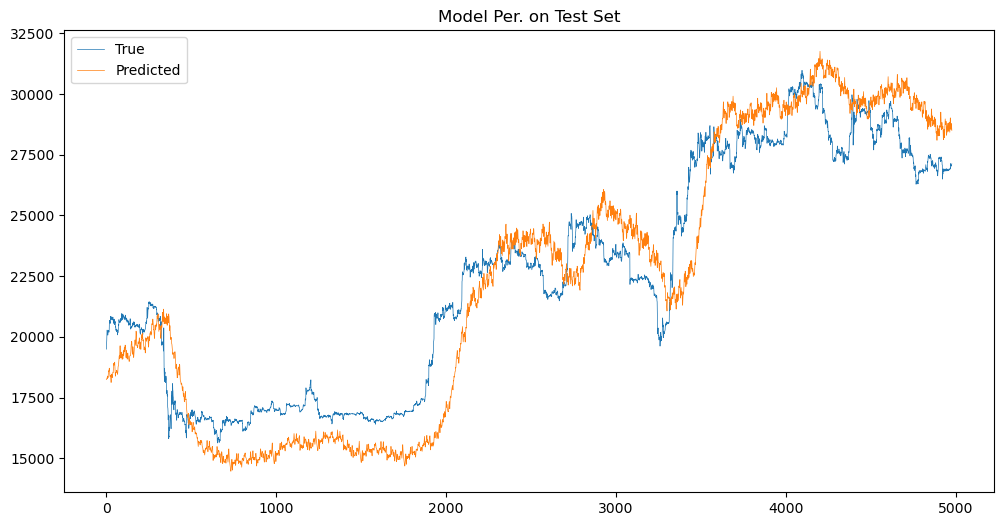

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=192, 
    next_ith=24,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_192_24.pt").run_training_testing()

## Close Column Only

#### Close Column Only (Input: last 12 data points, Output: the next First future data)

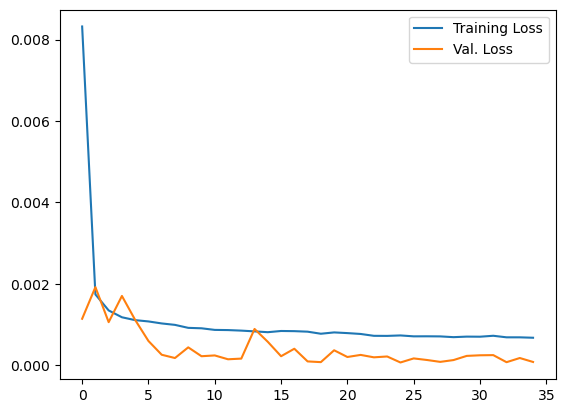

Current MAE 0.006793627218901663
Best MAE 0.005843119477792696
Early stopping triggered
Test MSE: 168751.90625, Test MAE: 323.310791015625


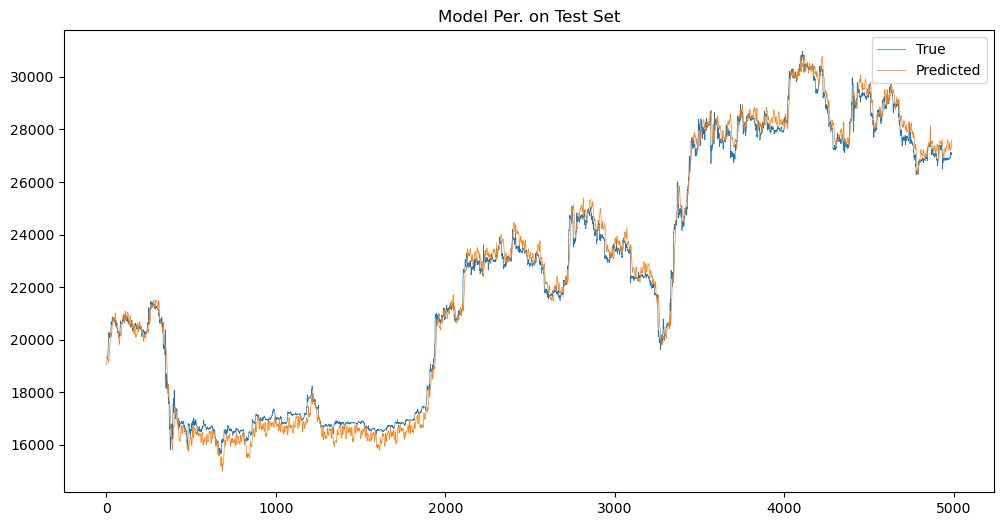

In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=12, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_12_1.pt").run_training_testing()

#### Close Column Only (Input: last 12 data points, Output: the next 12th future data)

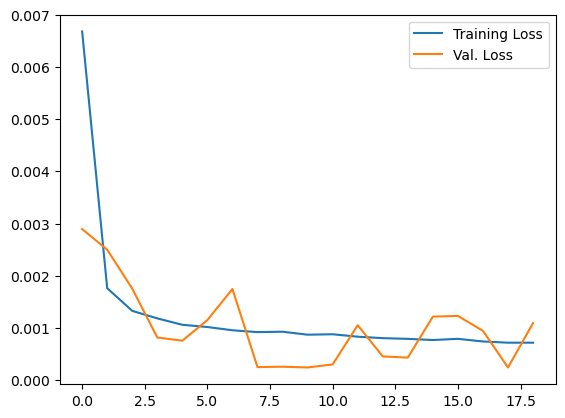

Current MAE 0.03081947279483104
Best MAE 0.012155550808377666
Early stopping triggered
Test MSE: 1206645.75, Test MAE: 952.6201782226562


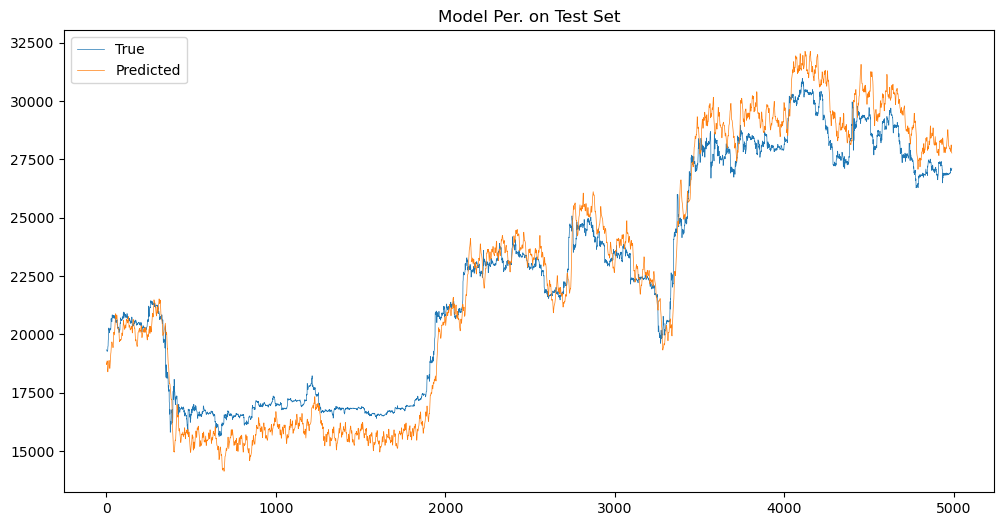

In [5]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=12, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_12_12.pt").run_training_testing()

#### Close Column Only (Input: last 96 data points, Output: the next First future data)

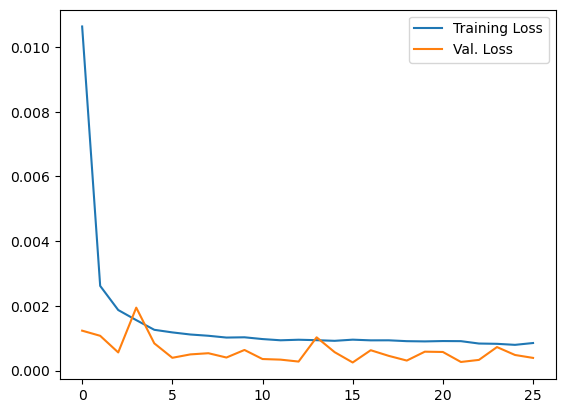

Current MAE 0.016215747156915598
Best MAE 0.012142168388233978
Early stopping triggered
Test MSE: 958898.6875, Test MAE: 755.988525390625


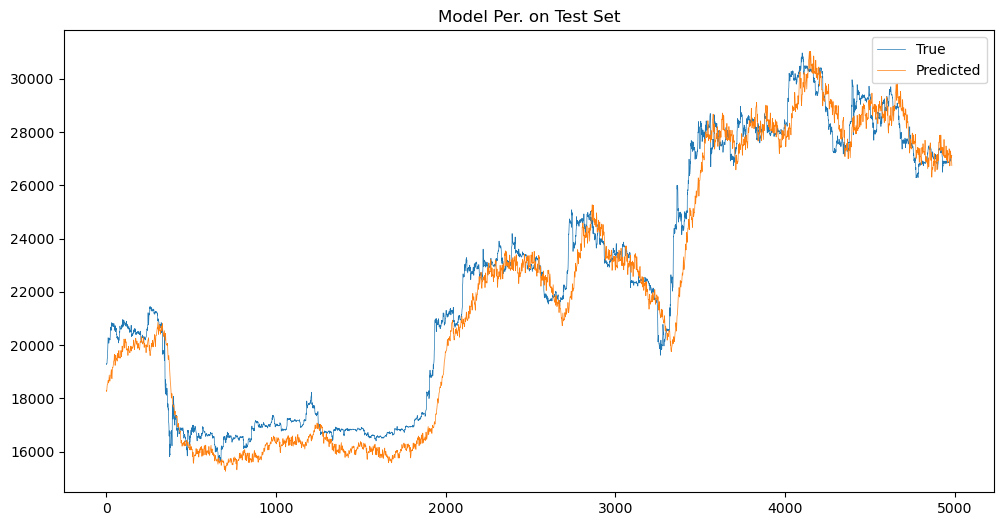

In [6]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_96_1.pt").run_training_testing()

#### Close Column Only (Input: last 96 data points, Output: the next 12th future data)

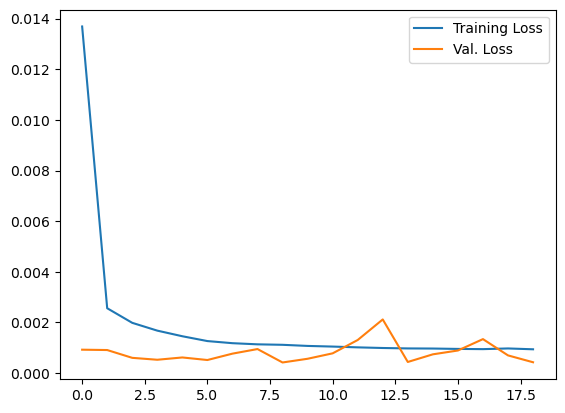

Current MAE 0.01592957333513621
Best MAE 0.014796547542354556
Early stopping triggered
Test MSE: 1289945.75, Test MAE: 898.4251708984375


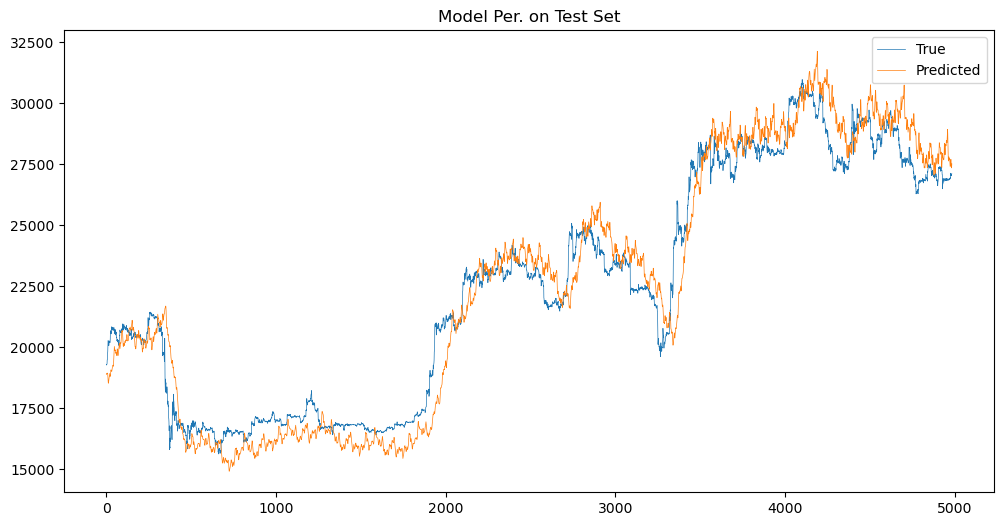

In [7]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_96_12.pt").run_training_testing()

#### Close Column Only (Input: last 504 data points, Output: the next 12 future data)

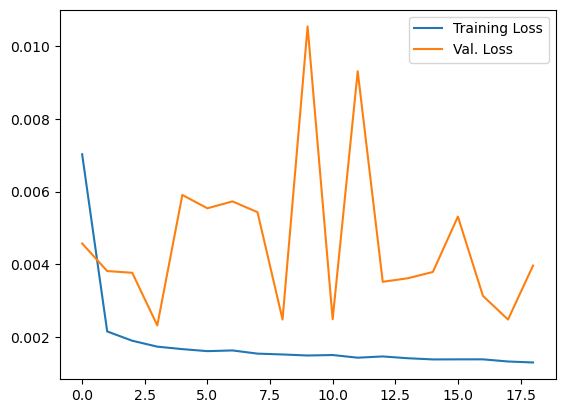

Current MAE 0.04434759570150595
Best MAE 0.03490465055883987
Early stopping triggered
Test MSE: 4057064.0, Test MAE: 1732.051025390625


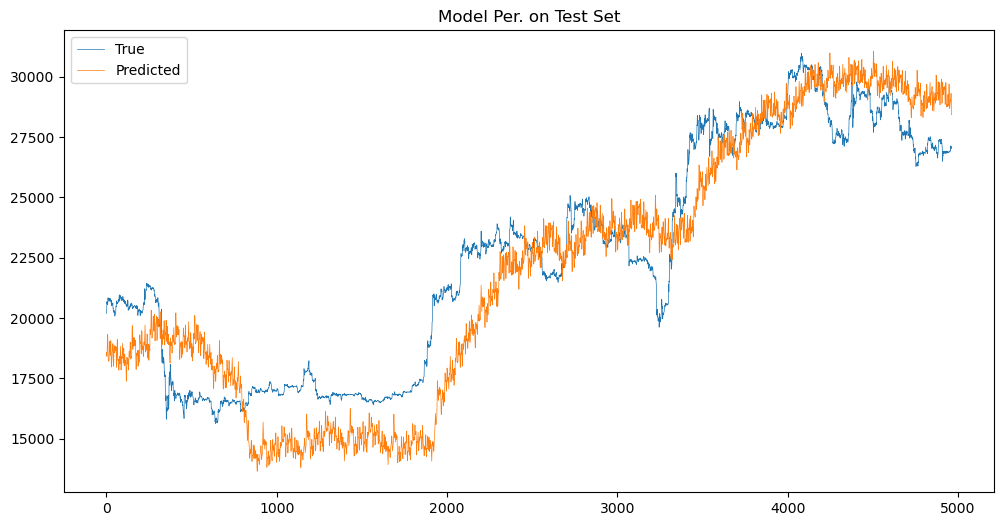

In [8]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=504, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_504_12.pt").run_training_testing()

## Top Columns

#### Top Columns (Input: last 12 data points, Output: the next First future data)

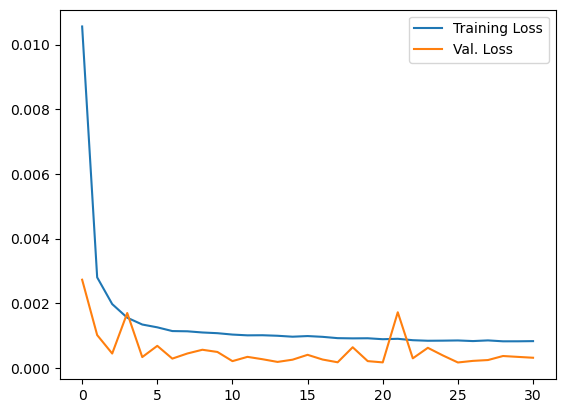

Current MAE 0.013600778955078406
Best MAE 0.00887203389096622
Early stopping triggered
Test MSE: 4294490.0, Test MAE: 1608.0950927734375


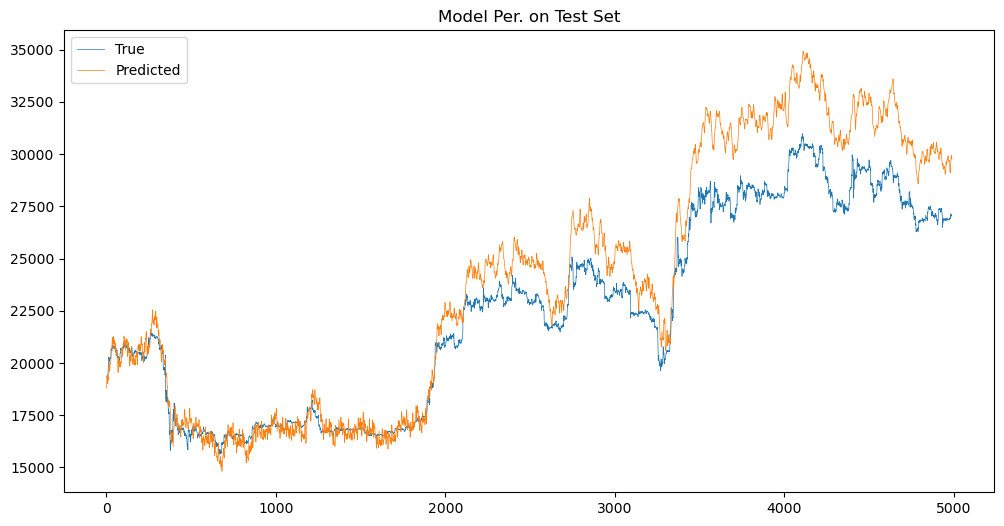

In [10]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=12, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_close&10_col_best_model_12_1.pt").run_training_testing()

#### Top Columns (Input: last 12 data points, Output: the next 12th future data)

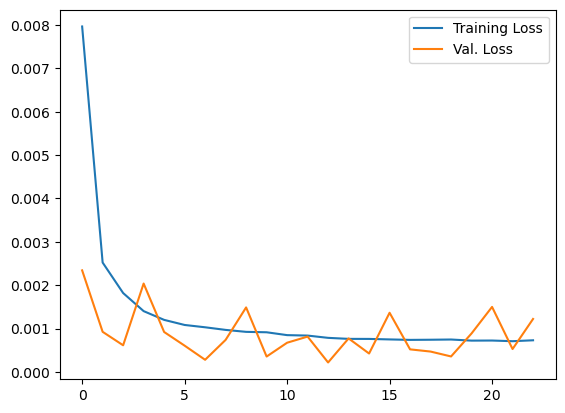

Current MAE 0.028230898503479998
Best MAE 0.010893705745362815
Early stopping triggered
Test MSE: 576629.125, Test MAE: 570.20263671875


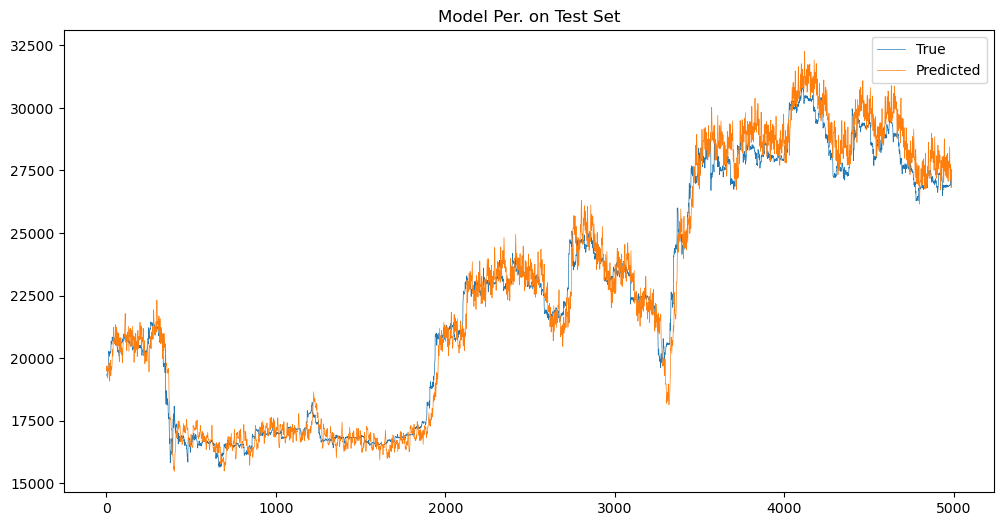

In [11]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=12, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_close&10_col_best_model_12_12.pt").run_training_testing()

#### Top Columns (Input: last 96 data points, Output: the next First future data)

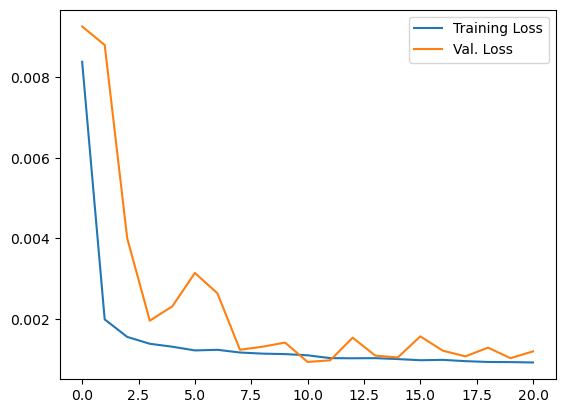

Current MAE 0.027892309510585297
Best MAE 0.023464123003461297
Early stopping triggered
Test MSE: 2024030.125, Test MAE: 1132.928955078125


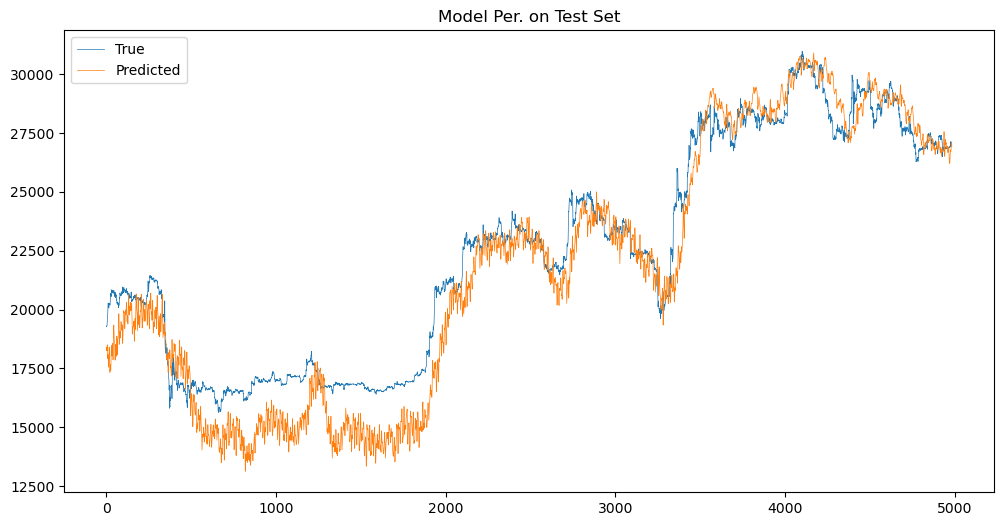

In [12]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_close&10_col_best_model_96_1.pt").run_training_testing()

#### Top Columns (Input: last 96 data points, Output: the next 12th future data)

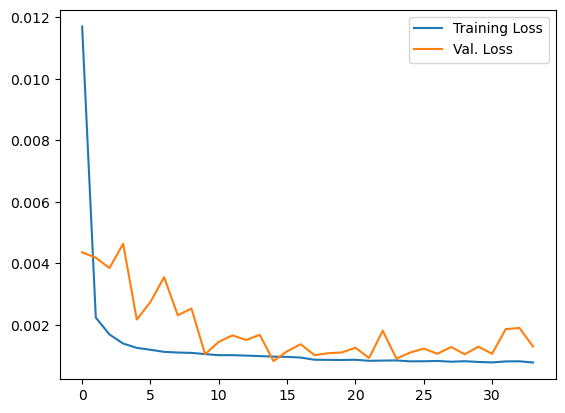

Current MAE 0.028457399819458853
Best MAE 0.021958936437856808
Early stopping triggered
Test MSE: 5150821.5, Test MAE: 2036.7135009765625


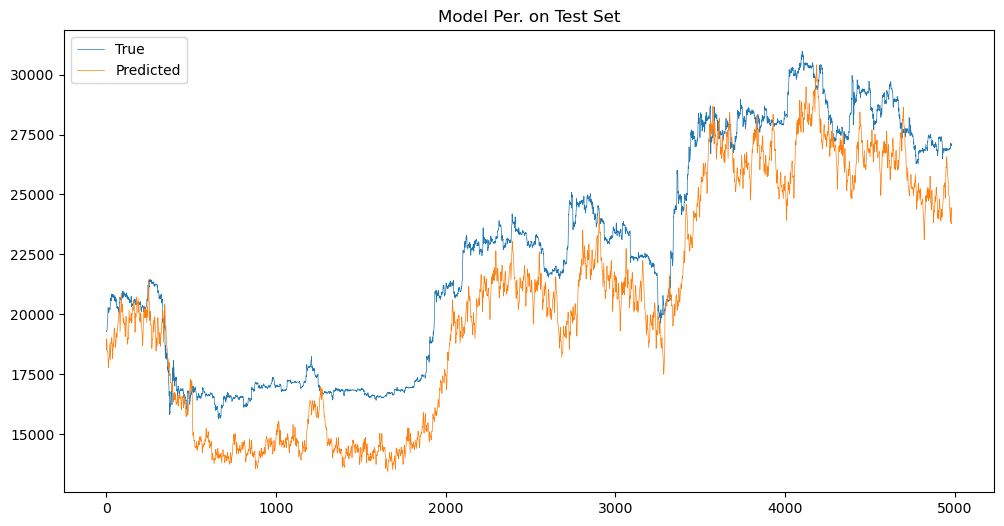

In [13]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_close&10_col_best_model_96_12.pt").run_training_testing()

#### Top Columns (Input: last 504 data points, Output: the next 12 future data)

In [14]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=504, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_close&10_col_best_model_504_12.pt").run_training_testing()

torch.Size([89349, 504, 11])
torch.Size([89349, 1, 1])
model name is  VanillaTimeSeriesTransformer


OutOfMemoryError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 0; 7.79 GiB total capacity; 4.51 GiB already allocated; 34.50 MiB free; 4.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF